#Spectral Temperature Estimation

##Problem Statement

A spectral radiometer is used to determine the surface temperature of a hot object exposed to sunlight.  The surface normal vector is pointing directly towards the sun. 

The temperature and emissivity of the object surface, as well as the temperature of the sun are unknown.  
 The object is considerably hotter than the environment, hence atmospheric path radiance and reflected ambient flux can be ignored. Ignore atmospheric transmittance  between the sun and the object and between the object and the sensor.  The measurement results are corrupted by noise.  The sun and object both radiate as Planck radiators. Emissivity is constant at all wavelengths.

Three different objects were characterised, each with different sun temperature, object temperature and object surface emissivity values. In other words, these are three completely independent cases.  The spectral measured radiance for all three cases are contained in the file  
`https://raw.githubusercontent.com/NelisW/pyradi/master/pyradi/data/EOSystemAnalysisDesign-Data/twoSourceSpectrum.txt`  
The first column in the file is wavelength in $\mu$m, and the remaining three columns are spectral radiance data for the three cases in W/(m$^2$.sr.$\mu$m).

1. Develop a model for the measurement setup; complete with mathematical description and a diagram of the setup. [5]

2. Develop two different techniques to solve the model parameters (sun temperature, object temperature and object emissivity) for the given spectral data. [13]

3. Evaluate the two techniques  in terms of accuracy and risk in finding a stable and true solution. [2]

[20]

In [1]:
from IPython.display import display
from IPython.display import Image
from IPython.display import HTML
%matplotlib inline
import numpy as np
from scipy.optimize import curve_fit

import pyradi.ryutils as ryutils
import pyradi.ryplot as ryplot
import pyradi.ryplanck as ryplanck

#make pngs at required dpi
import matplotlib as mpl
mpl.rc("savefig", dpi=75)
mpl.rc('figure', figsize=(10,8))


##Prepare the data file
This section is not part of the solution, it is used to prepare the data for the problem statement. 
Calculate the spectral radiance curves from first principles.

In [2]:
filename = 'twoSourceSpectrum.txt'

In [3]:
def bbfunc(wl,tsun,tobj,emis):
    """Given the two temperatures and emissivity, calculate the spectum.
    """
    lSun = 2.175e-5 * ryplanck.planck(wl,tsun, 'el') / np.pi # W/(m2.sr.um)
    lObj = ryplanck.planck(wl,tobj, 'el') / np.pi # W/(m2.sr.um)
    return  lSun * (1 - emis) + lObj * emis

In [4]:
def percent(val1, val2):
    return 100. * (val1  -val2) / val2

Plot the data for visual check. Plot on log scale to capture the wide range of values.

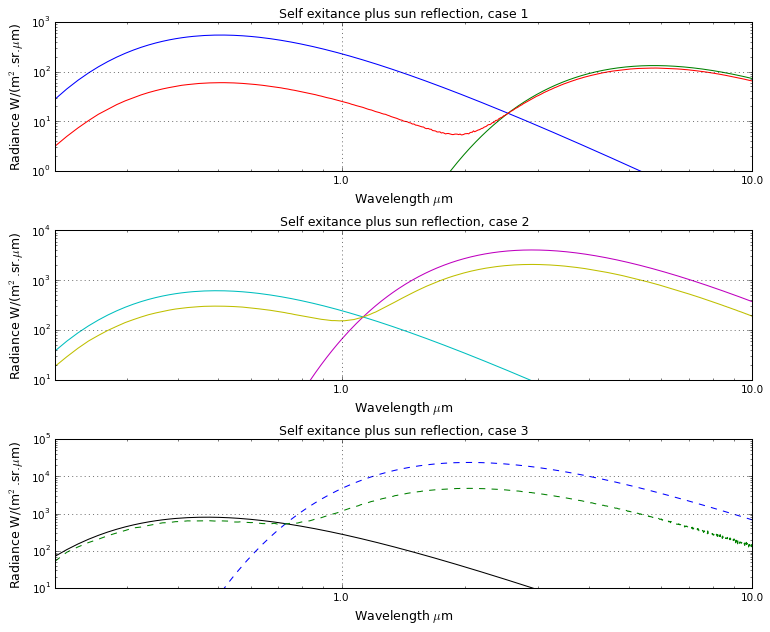

In [5]:
wl = np.linspace(0.2, 14, 1000).reshape(-1,1)  # wavelength 

tempsuns = [5715, 5855, 6179]
tempobjs = [503, 998, 1420]
emiss = [0.89, 0.51, 0.2]
plotmins = [1e-0, 1e1, 1e1]
plotmaxs = [1e3, 1e4, 1e5]
noise = [.1, .5 , 10]

radiancesun = np.zeros((wl.shape[0], len(emiss)))
radianceobj = np.zeros((wl.shape[0], len(emiss)))
radiancesum = np.zeros((wl.shape[0], len(emiss)))
outarr = wl

p = ryplot.Plotter(2,3,1,figsize=(12,10))
for i,(tempsun, tempobj,emis, plotmin, plotmax) in enumerate(zip(tempsuns, tempobjs,emiss, plotmins, plotmaxs)):
    radiancesum[:,i] = bbfunc(wl,tempsun,tempobj,emis) + noise[i] * np.random.normal(size=wl.shape[0])
    radiancesun[:,i] = bbfunc(wl,tempsun,tempobj,0.0) 
    radianceobj[:,i] = bbfunc(wl,tempsun,tempobj,1.0) 

    outarr = np.hstack((outarr, radiancesum[:,i].reshape(-1,1)))

    p.logLog(1+i,wl, radiancesun[:,i],
             'Self exitance plus sun reflection, case {}'.format(i+1),
             'Wavelength $\mu$m', 'Radiance W/(m$^2$.sr.$\mu$m)',
             maxNX=4, pltaxis=[0.2, 10, plotmin, plotmax])
    p.logLog(1+i,wl, radianceobj[:,i],
             'Self exitance plus sun reflection, case {}'.format(i+1),
             'Wavelength $\mu$m', 'Radiance W/(m$^2$.sr.$\mu$m)',
           maxNX=4, pltaxis=[0.2, 10, plotmin, plotmax])
    p.logLog(1+i,wl, radiancesum[:,i],
             'Self exitance plus sun reflection, case {}'.format(i+1),
             'Wavelength $\mu$m', 'Radiance W/(m$^2$.sr.$\mu$m)',
           maxNX=4, pltaxis=[0.2, 10, plotmin, plotmax])

#data not to be written out again, already committed to the pyradi web site.
if False:
    with open(filename, 'wt') as fout:
        fout.write(('{:25s}' * 4 + '\n').format('wavelength-um', 'Radiance-case1', 'Radiance-case2', 'Radiance-case3'))
        np.savetxt(fout, outarr)    

##Solution

Recognise that the signature comprises two components: reflected sunlight and self emittance.

The total signature is given by 
$L_{\rm tot} = \epsilon \,L_{\rm bb}(T_{\rm obj}) + (1\,-\,\epsilon)\, \psi L_{\rm bb}(T_{\rm sun})$,
where 
$\psi=A_{\rm sun}/(\pi R_{\rm sun}^2) =2.1757\times10^{-5}$ [sr/sr] follows from the geometry between the earth and the sun, 
$\epsilon$ is the object surface emissivity,
$T_{\rm obj}$ the object temperature, and 
$T_{\rm sun}$ is the sun surface temperature.

The three variables to be solved are 
$\epsilon$, 
$T_{\rm obj}$, and 
$T_{\rm sun}$.

The problem is coded in mathematical form as

    def bbfunc(wl,tsun,tobj,emis):
        """Given the two temperatures and emissivity, calculate the spectum.
        """
        lSun = 2.175e-5 * ryplanck.planck(wl,tsun, 'el') / np.pi # W/(m2.sr.um)
        lObj = ryplanck.planck(wl,tobj, 'el') / np.pi # W/(m2.sr.um)
        return  lSun * (1 - emis) + lObj * emis

The first step in the analysis is to plot the supplied data.  Sometimes it helps to plot the data in different plotting scales.  In this case the sun and object are Planck radiators (given in problem statement) where the wavelength of peak radiance is related to the temperature by Wien's displacement law $T = 2898/\lambda_{p}$.  Exploiting this fact, the radiance curves are plotted on a Wien-law scale where wavelength is converted to temperature.  For an ideal Planck-law radiator the radiance peak can be used to read of the temperature on the temperature scale.

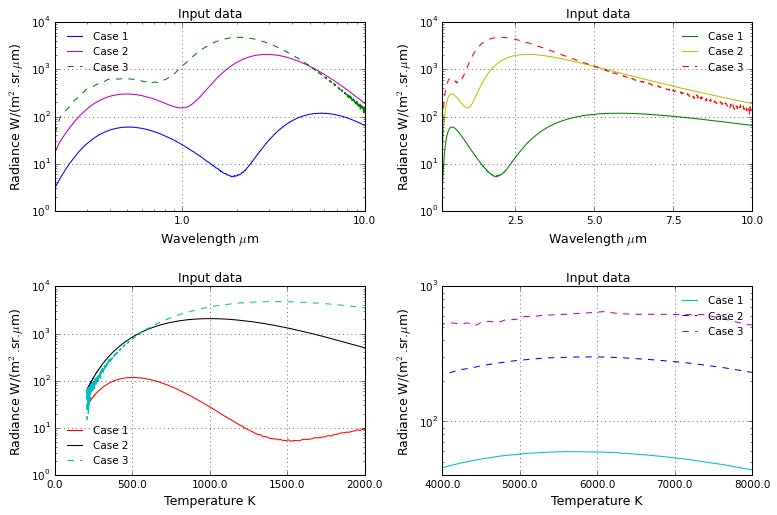

In [6]:
radIn = np.loadtxt(filename, skiprows=1)
wl = radIn[:,0]
q = ryplot.Plotter(1,2,2,figsize=(12,8))

for i in range(0,len(emiss)):

    tPeak = 2898. / wl
    
    q.logLog(1,wl, radIn[:,i+1],
             'Input data', 'Wavelength $\mu$m', 'Radiance W/(m$^2$.sr.$\mu$m)',
             label=['Case {}'.format(i+1)], maxNX=4, pltaxis=[0.2, 10, 1e0, 1e4])
    q.semilogY(2,wl, radIn[:,i+1],
             'Input data', 'Wavelength $\mu$m', 'Radiance W/(m$^2$.sr.$\mu$m)',
             label=['Case {}'.format(i+1)], maxNX=4, pltaxis=[0.2, 10, 1e0, 1e4])
    q.semilogY(3,tPeak, radIn[:,i+1],
             'Input data', 'Temperature K', 'Radiance W/(m$^2$.sr.$\mu$m)',
             label=['Case {}'.format(i+1)], maxNX=4, pltaxis=[0., 2000., 1e0, 1e4])
    q.semilogY(4,tPeak, radIn[:,i+1],
             'Input data', 'Temperature K', 'Radiance W/(m$^2$.sr.$\mu$m)',
             label=['Case {}'.format(i+1)], maxNX=4, pltaxis=[4000., 8000., 4e1, 1e3])

Analysing the graphs above, rough estimates of the temperatures can be formed.  The object temperatures can be estimated relatively easily from the bottom-left curve: approximately 500 K, 1000 K and 1500 K.  The sun temperature is not so easily estimated: 5500 K, 5900 K and 6000 K.  These estimates in themselves are inaccurate for final results, but can guide subsequent analysis.

###Method 1: Differentiating Spectral Radiance

The first method is a refinement of the peak-detection method used above for the first order estimates.  It relies on the mathematical method that the location of peaks and minima can be determined by the zero crossings of the first derivative.  The derivative is calculated by using the Numpy `diff` method.  The problem with this technique is that the measurement is somewhat noisy, and the derivation operator amplifies the noise.  So we are making a noisy signal more noisy and then look for zero crossings - a method that hold tremendous promise to fail.  The noisy zero crossings make it very difficult to determine the true zero crossing accurately.   We will use the estimates determined above to limit the search range.

The data is noisy, so a filter was used to improve the signal to noise somewhat.  There is however the risk that the filtering process may interfere with the true nature of the data, so the degree of filtering is limited.  The Savitzky-Golay filter is used here.  This filter is commonly used in the spectroscopy community.

In the code below the first derivative is calculated using `numpy.diff` and then normalised (because the absolute scale is not important).  The differentiated signal is plotted for inspection. Note the noise in the signal - filtering seems to help quite a lot (but not sufficiently to count zero crossings naively).  

In the analysis below uses privileged problem data, but only to determine the error between the answers and the true temperatures.

First detemine the approximate wavelength ranges where the estimated zero crossing occur, based on temperatures read of from the above graphs.

In [7]:
#temperatures read of from above graphs
tLo = np.asarray([[400, 600],[900,1100],[1400,1600]])
tHi = np.asarray([[5000, 6500],[5000,6500],[5000,6500]])
#get peak wavelengths associated with these temperatures
wLo = 2897.77 / tLo
wHi = 2897.77 / tHi

print(tLo)
print(tHi)
print(wLo)
print(wHi)

[[ 400  600]
 [ 900 1100]
 [1400 1600]]
[[5000 6500]
 [5000 6500]
 [5000 6500]]
[[ 7.244425    4.82961667]
 [ 3.21974444  2.63433636]
 [ 2.06983571  1.81110625]]
[[ 0.579554    0.44581077]
 [ 0.579554    0.44581077]
 [ 0.579554    0.44581077]]


The following function does the hard work to find the maxima.  First find all the zero crossings in the data, but there are many such crossings (at least three actual crossings) because of the noise in the signal.  Near each actual zero crossing there are a multitude of noisy crossings.  We are unable to tell the actual crossing from the noise-caused ones.  This is done by selecting (1) a spectral range according to the expected temperature (by Wien law), (2) finding all the zero crossings in the spectral range, (3) using the wavelengths where the zero crossings occur to determine the temperatures of such zero crossings, and (4) taking the mean value of the temperatures associated with all the zero crossings in the filter spectral range.

The emissivity determined by solving from $L_{\rm tot} = \epsilon \,L_{\rm bb}(T_{\rm obj}) + (1\,-\,\epsilon)\, L_{\rm bb}(T_{\rm sun})$, having determined the sun and object temperatures.

Finally, print the estimated temperature and the errors relative to the original values used to construct the problem.

In [8]:
def processTempEmis(i, data, datadiff, dataName, tempsuns, tempobjs, emiss, wldcen, wLo, wHi):
    """
    data is the radiance spectrum 
    datadiff is the radiance spectrum differential
    dataName is the text name to be used in printout
    tempsuns, tempobjs, emiss are the reference data to determine errors
    wldcen is wavelength values at the differentiation samples
    wLo is the low temperature spectral range containing zero crossing
    wHi is the high temperature spectral range containing zero crossing
    """
    #find all zero crossings (all wavelengths) to determine inflection wavelengths
    zero_crossings = np.where(np.diff(np.sign(datadiff)),1,0)

    # set up spectral filters according to the estimated temperature ranges
    wLofilter = np.where((wldcen >= wLo[i,1]) & (wldcen <= wLo[i,0]),1., 0.)[1:]
    wHifilter = np.where((wldcen >= wHi[i,1]) & (wldcen <= wHi[i,0]),1., 0.)[1:]

    #find indexes of zero crossings within the spectral filters
    zcHi = np.where(zero_crossings*wHifilter)
    zcLo = np.where(zero_crossings*wLofilter)

    #use Wien law to determine temperature
    # but this could be many samples if more than one zero crossing, take mean
    bbtempHi = np.mean(2897.77 / wldcen[zcHi])
    bbtempLo = np.mean(2897.77 / wldcen[zcLo])
  
    #calculate emissivity, given the two above temperatures
    lsun = 2.15e-5 * ryplanck.planck(wldcen,bbtempHi, 'el') / np.pi # W/(m2.sr.um)
    lobj = ryplanck.planck(wldcen, bbtempLo, 'el') / np.pi # W/(m2.sr.um)
    estEmis = np.average((data[1:] - lsun)/(lobj - lsun))
   
    print('\nCase {} {}:'.format(i+1, dataName))
    print('Estimated Tsun={:.2f}  Tobj={:.2f}  emis={:.4f}'.format(bbtempHi,bbtempLo,estEmis ))   
    print('True      Tsun={:.2f}  Tobj={:.2f}  emis={:.4f}'.format(tempsuns[i], tempobjs[i], emiss[i]))   
    print('Error     Tsun={:.2f}%    Tobj={:.2f}%   emis={:.4f}%'.format(
        percent(bbtempHi, tempsuns[i]),percent(bbtempLo, tempobjs[i]),percent(estEmis, emiss[i])))   
    return bbtempHi, bbtempLo, estEmis


Case 1 Raw:
Estimated Tsun=5672.88  Tobj=494.60  emis=0.8723
True      Tsun=5715.00  Tobj=503.00  emis=0.8900
Error     Tsun=-0.74%    Tobj=-1.67%   emis=-1.9937%

Case 1 Filtered:
Estimated Tsun=5830.56  Tobj=507.99  emis=0.8695
True      Tsun=5715.00  Tobj=503.00  emis=0.8900
Error     Tsun=2.02%    Tobj=0.99%   emis=-2.3037%
------------------------------

Case 2 Raw:
Estimated Tsun=5997.25  Tobj=999.04  emis=0.5102
True      Tsun=5855.00  Tobj=998.00  emis=0.5100
Error     Tsun=2.43%    Tobj=0.10%   emis=0.0408%

Case 2 Filtered:
Estimated Tsun=5997.25  Tobj=999.02  emis=0.5102
True      Tsun=5855.00  Tobj=998.00  emis=0.5100
Error     Tsun=2.43%    Tobj=0.10%   emis=0.0446%
------------------------------

Case 3 Raw:
Estimated Tsun=6366.81  Tobj=1468.71  emis=0.1552
True      Tsun=6179.00  Tobj=1420.00  emis=0.2000
Error     Tsun=3.04%    Tobj=3.43%   emis=-22.3777%

Case 3 Filtered:
Estimated Tsun=5997.25  Tobj=1427.24  emis=0.1946
True      Tsun=6179.00  Tobj=1420.00  emis=0.20

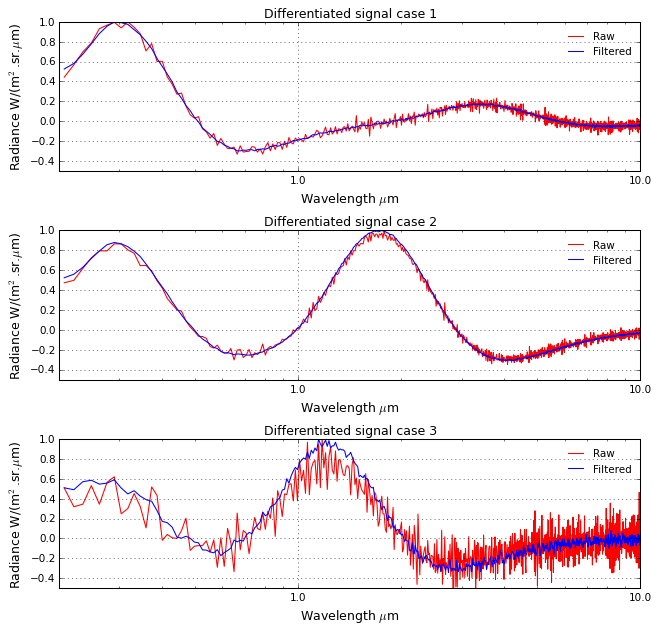

In [9]:
radiancesumdif = np.zeros((wl.shape[0]-1, len(emiss)))
wldiff = np.diff(radIn[:,0],axis=0).reshape(-1,1)
wldcen = (radIn[:-1,0] + radIn[1:,0]) / 2.
p = ryplot.Plotter(2,3,1,figsize=(10,10))

for i in range(0,len(emiss)):

    #take derivative and normalise because scale is not important
    radiancesumdif[:,i] = (np.diff(radIn[:,i+1],axis=0).reshape(-1,1)/ wldiff).reshape(-1,)
    radiancesumdif[:,i] /= np.max(radiancesumdif[:,i],axis=0)
    
    #the derivative is too noisy, so filter the signal to suppress noise
    sgfiltered = ryutils.savitzkyGolay1D(radIn[:,i+1], window_size=11, order=3, deriv=0, rate=1)
    sgfiltereddif = (np.diff(sgfiltered,axis=0).reshape(-1,1)/ wldiff).reshape(-1,)
    sgfiltereddif /= np.max(sgfiltereddif,axis=0)

    #plot
    p.semilogX(1+i,wldcen, radiancesumdif[:,i],'Differentiated signal case {}'.format(i+1),
        'Wavelength $\mu$m','Radiance W/(m$^2$.sr.$\mu$m)', plotCol=['r'],maxNX=4, 
        pltaxis=[0.2, 10, -0.5, 1.0],label=['Raw'])
    p.semilogX(1+i,wldcen, sgfiltereddif,'Differentiated signal case {}'.format(i+1),
        'Wavelength $\mu$m', 'Radiance W/(m$^2$.sr.$\mu$m)',plotCol=['b'], maxNX=4, 
        pltaxis=[0.2, 10, -0.5, 1.0],label=['Filtered'])
    
    #process to find the zero crossings
    processTempEmis(i, radIn[:,i+1], radiancesumdif[:,i], 'Raw', tempsuns, tempobjs, emiss, wldcen, wLo, wHi)
    processTempEmis(i, radIn[:,i+1], sgfiltereddif, 'Filtered', tempsuns, tempobjs, emiss, wldcen, wLo, wHi)
    print(30*'-')

From the above results, it is evident that the filtered data set did not really provide a better answer: proof that filtering affects the data and subsequent results.

It can be argued that the use of a spectral filtering/selection range for each of the three cases already predetermines the final solution. Note however that the ranges were selected on the basis of the peak evident in the input data.  Taking the average of the calculated zero crossings' temperatures is somewhat brute force, but appears to work reasonably well.

The method is complex and requires some fine tuning and careful algorithmic design. It is however a 'general' solution in the sense that it will work for any scenario.

###Method 2: Curve fitting to a known equation

The second method is far simpler and yields better answers.  The problem can be stated in the following mathematical form:
$L_{\rm tot} = \epsilon \,L_{\rm bb}(T_{\rm obj}) + (1\,-\,\epsilon)\, L_{\rm bb}(T_{\rm sun})$.  This function is implemented in the function `bbfunc()`.  Finding the solution is then simply a matter of using the `scipy.optimize.curve_fit` function to find the sun temperature, object temperature and emissivity that will provide the best fit.  This approach is motivated on the premise that the problem statement supports a direct and accurate mathematical formulation, which can then be used curve fitting the given data.

In [10]:
radIn = np.loadtxt(filename, skiprows=1)
for i in range(0,len(emiss)):
    popt, pcov = curve_fit(bbfunc,radIn[:,0], radIn[:,i+1], p0=(6000., 1000., .5) )
   
    print('\nCase {}:'.format(i+1))
    print('Estimated Tsun={:.2f}  Tobj={:.2f}  emis={:.4f}'.format(popt[0],popt[1],popt[2]))   
    print('True      Tsun={:.2f}  Tobj={:.2f}  emis={:.4f}'.format(tempsuns[i], tempobjs[i], emiss[i]))   
    print('Error     Tsun={:.2f}%    Tobj={:.2f}%   emis={:.4f}%'.format(
        percent(popt[0], tempsuns[i]),percent(popt[1], tempobjs[i]),percent(popt[2], emiss[i])))       


Case 1:
Estimated Tsun=5715.65  Tobj=502.99  emis=0.8901
True      Tsun=5715.00  Tobj=503.00  emis=0.8900
Error     Tsun=0.01%    Tobj=-0.00%   emis=0.0141%

Case 2:
Estimated Tsun=5855.00  Tobj=998.00  emis=0.5100
True      Tsun=5855.00  Tobj=998.00  emis=0.5100
Error     Tsun=0.00%    Tobj=0.00%   emis=-0.0000%

Case 3:
Estimated Tsun=6172.92  Tobj=1419.93  emis=0.2001
True      Tsun=6179.00  Tobj=1420.00  emis=0.2000
Error     Tsun=-0.10%    Tobj=-0.01%   emis=0.0645%


This method is simple and very accurate, but it does require confirmation that the measured scenarios correspond with the model used in the data analysis.  It is not a general solution, but specifically tuned to the equation used.

## Python and [module versions, and dates](http://nbviewer.ipython.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-0-Scientific-Computing-with-Python.ipynb)

In [11]:
%load_ext version_information
%version_information numpy, scipy, matplotlib

Software versions
Python 2.7.8 32bit [MSC v.1500 32 bit (Intel)]
IPython 3.0.0
OS Windows 7 6.1.7601 SP1
numpy 1.9.2
scipy 0.15.1
matplotlib 1.4.3
Tue Jun 16 11:10:44 2015 South Africa Standard Time